In [1]:
## Enrich of Bakken hem markers in this dataset
library(Seurat)
library(dplyr)
library(ggplot2)
source("./auc.fun.R")
inputdir <- "./load_files/"
outputdir <- "./report/"

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘AUCell’


The following object is masked from ‘package:base’:

    cbind




In [2]:
##---------------------------------------------------------------------------------------------
## Get the markers of hem regions 
## Old script to calculate the hem markers
if (FALSE){
source("/home/sm2726/project/common_scripts/private_R_pack/scCodes.R")


## cp /home/sm2726/project/cortex_development/public/data/
##    macaque_dev_atlas_array/micro/filtered_data.Rdata ./load_files/macaque_dev_microarray.Rdata
load("./load_files/filtered_data.Rdata")
##new_fexp, sample_meta
sample_meta <- sample_meta %>%
                mutate(well_id = as.character(well_id)) %>%
                column_to_rownames("well_id") %>%
                subset(age == "E40") ##%>%
                ##subset(structure_acronym != "V1vz")

data_use <- new_fexp[, rownames(sample_meta)] %>% as.matrix()


##all_regs <- levels(as.factor(sample_meta$structure_acronym))
spec_res <- parallel_spec(data = data_use, 
                          header = setNames(sample_meta$structure_acronym, rownames(sample_meta)), 
                          medianfilter=0, cuts= FALSE, distshape=0, nCores=20)$specs
saveRDS(spec_res, file = paste0(inputdir, "macaque_dev_microarray_specs.rds"))


spec_res <- readRDS(file = paste0(inputdir, "macaque_dev_microarray_specs.rds"))
all_markers <- extract_markers(input_spec = spec_res, min_spec_quantile = NULL, spec_thre = 0.15, 
                               rank_ratio = 0.9, fc_thre = 6, return_spec = FALSE)$all
saveRDS(all_markers, file = paste0(inputdir, "macaque_dev_microarray_markers.rds"))   
}

Warning message in max(densCurve$y[nextMaxs]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(densCurve$y[nextMaxs]):
“no non-missing arguments to max; returning -Inf”
Warning message in max(densCurve$y[nextMaxs]):
“no non-missing arguments to max; returning -Inf”


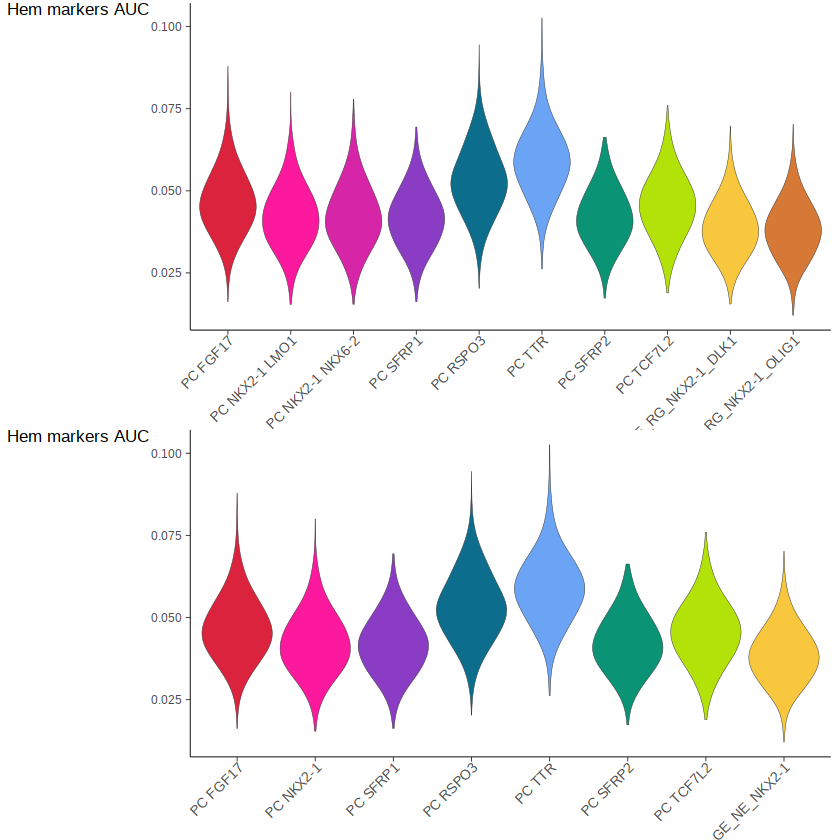

In [3]:
##---------------------------------------------------------------------------------------------
## Check marker enrichment
seu <- readRDS(file = paste0("../overview/load_files/", "PAT_inte.organizer.inte.rds"))
all_markers <- readRDS(file = paste0(inputdir, "macaque_dev_microarray_markers.rds"))


## Get the AUROC scores 
all_auc <- GetModuleScore(assay.data = seu$RNA@data, 
                          features = all_markers, method = "aucell", 
                          file_name = "PAT_match_pub_AUC", input_dir = inputdir)$auc
seu[["auc"]] <- CreateAssayObject(data = t(all_auc))



cls_cols <- list(subtype = c("#db233e", "#fc199d", "#d626a7", "#8b3cc4", 
                             "#0c6e8c", "#6ba4f4", "#0b9376", "#b3e209", 
                             "#f9c73e", "#d67937") %>% 
                 setNames(., c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", "PC SFRP1", 
                               "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2", 
                               "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1")),
                subclass = c("#db233e", "#fc199d", "#8b3cc4", 
                             "#0c6e8c", "#6ba4f4", "#0b9376", "#b3e209", "#f9c73e") %>%
                setNames(., c("PC FGF17", "PC NKX2-1", "PC SFRP1", 
                              "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2", "GE_NE_NKX2-1")))

pdata <- seu@meta.data[, c("subtype", "subclass")] %>%
            cbind(., t(seu$auc@data["Hem", ,drop = FALSE])) %>%
            mutate(subtype = factor(subtype, levels = c("PC FGF17", 
                                                        "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", "PC SFRP1", 
                                                        "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2", 
                                                        "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1"))) %>%
            mutate(subclass = factor(subclass, levels = c("PC FGF17", "PC NKX2-1", "PC SFRP1", 
                                                          "PC RSPO3", "PC TTR", 
                                                          "PC SFRP2", "PC TCF7L2", "GE_NE_NKX2-1")))
plist <- lapply(c("subtype", "subclass"), function(xx) {
        p <- ggplot(pdata, aes_string(x = xx, y = "Hem", fill = xx)) + 
                geom_violin(scale = "width", size = 0.1, adjust = 2,trim =TRUE) + 
                theme_classic() + 
                labs(y = "Hem markers AUC") +
                scale_fill_manual(values = cls_cols[[xx]]) +
                theme(axis.title.x = element_blank(), 
                      axis.title.y = element_text(size = rel(0.9), angle = 0, hjust = 0.5, vjust = 1), 
                      axis.text.x = element_blank(), axis.line.x = element_blank(), 
                      axis.ticks.x = element_blank(), 
                      axis.text.y = element_text(size = rel(0.8)),
                      axis.line.y = element_line(size = 0.2), 
                      axis.ticks.y = element_line(size = 0.2), 
                      legend.position = "none", plot.margin = unit(c(-0.05, 0, -0.05, 0), "in"))
        p <- p +
                theme(axis.text.x=element_text(size = rel(0.9), angle = 45, hjust = 1, vjust = 1), 
                      axis.line.x = element_line(size = 0.2), axis.ticks.x = element_line(size = 0.2)) 
        return(p)
    })
pcbn <- patchwork::wrap_plots(plist, nrow = 2, ncol = 1)
pcbn

In [4]:
pdf(paste0(outputdir, "PAT_match_pub_AUC_violin.pdf"), width = 6, height = 6)
print(pcbn)
dev.off()

png 
  2

In [5]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] AUCell_1.8.0  ggplot2_3.3.0 dplyr_1.0.7   Seurat_3.1.5 

loaded via a namespace (and not attached):
  [1] Rtsne_0.15                  colorspace_1.4-1           
  [3] ellipsis_0.3.2     